In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v3
from draw import draw  #绘图函数
import tqdm

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v3.GridWorld_v3(forbiddenAreaScore=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


# 这个代码的目标是研究policy为0.2时，先采样getTrajectoryScore500次,对应的state value是如何的，虽然没有收敛到最优解

In [3]:
policy = 0.2 * np.ones((rows*columns,5))
episodes = [gridworld.getTrajectoryScore(nowState = 10,action = random.randint(0,4),policy = policy) 
            for i in range(500)]

In [4]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

  0%|          | 0/100 [00:00<?, ?it/s]

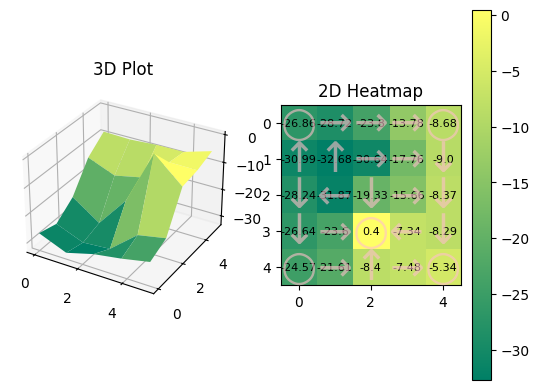

 20%|██        | 20/100 [00:00<00:01, 46.96it/s]

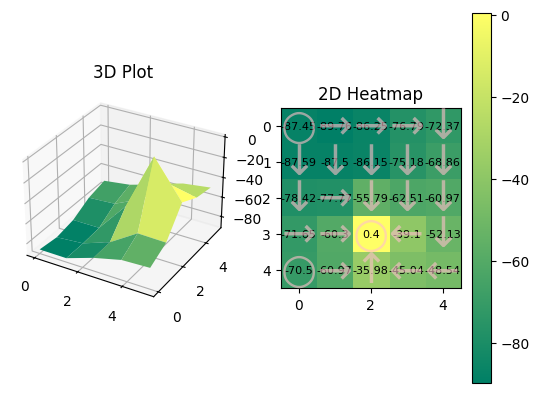

 39%|███▉      | 39/100 [00:01<00:01, 45.72it/s]

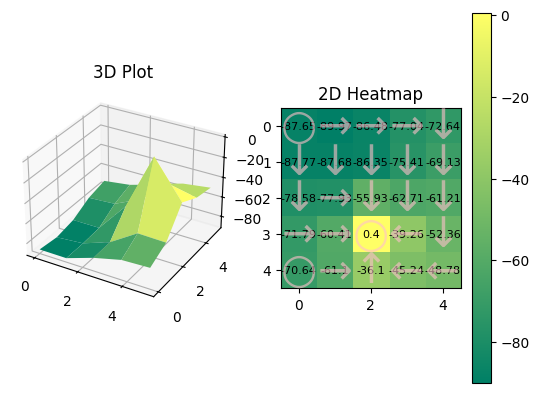

 58%|█████▊    | 58/100 [00:01<00:00, 43.73it/s]

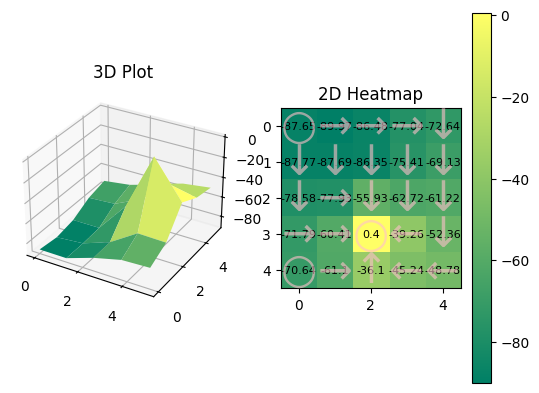

 78%|███████▊  | 78/100 [00:02<00:00, 45.80it/s]

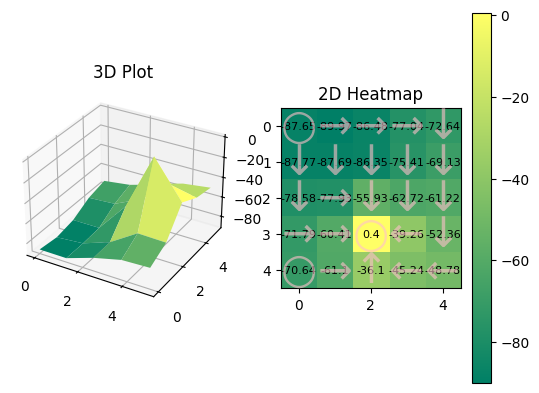

100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


In [5]:
# 外层循环，使用 tqdm 库显示进度条，总共迭代 100 次
for _ in tqdm.tqdm(range(100)):
    # 遍历所有的情节（episodes）
    for i in range(len(episodes)):
        # 逆序遍历当前情节中的每一个轨迹,从target位置往前遍历，这样效果会更好，使得更新更准确，减少了无关状态的干扰，在强化学习中，若从最初状态开始更新，后续的状态更新可能会因为错误的决策而进一步放大错误。逆序遍历从目标位置向前可以避免这种情况，让每次更新更依赖于高质量的后续状态信息
        for j in range(len(episodes[i])-1,-1,-1):
            # 获取当前轨迹
            trajectory = episodes[i][j]
            # 解包轨迹中的信息，包括当前状态、动作、得分、下一个状态、下一个动作和是否终止标志
            tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = trajectory
            # 获取下一个状态的值
            next_state_value = state_values[nextState]
            # 计算目标值，使用贝尔曼方程，当到达target状态时，不考虑下一个状态的值，这时1.0 - terminal为0
            target = tmpscore + (1.0 - terminal) * gamma * next_state_value
    
            # 计算时间差分（TD）误差
            TD_error = state_values[tmpstate] - target
            
            # 根据 TD 误差更新当前状态的值
            state_values[tmpstate] -= learning_rate * TD_error
            
    # 每迭代 20 次执行以下操作
    if _ % 20 == 0:
        # 随机初始化动作值函数
        action_values = np.random.rand(25,5)
        # 遍历所有状态和动作
        for i in range(25):
            for j in range(5):
                # 从网格世界中获取执行动作的得分和下一个状态
                score, nextState = gridworld.getScore(i,j)
                # 计算动作值函数
                action_values[i][j] = score + gamma * state_values[nextState]
        
        # 获取每个状态下的最优动作
        p = np.argmax(action_values,axis=1)
        # 绘制状态值和最优动作
        draw(state_values.reshape(5,5), p)